In [2]:
myPath <- .libPaths()
myPath <- c(myPath,"/home/yanhu/utils/R/R_packages")
.libPaths(myPath)

library(GenomicRanges)
library(SummarizedExperiment)
library(ggplot2)

In [3]:
# Fast running window sum. This runs a window with radius = r across the input vector x and calculates running sum
# For any position i, this sums x[(i - r + 1) : (i + r)]
conv <- function(x, # Input vector x
                 r # Window radius
                 ){
  smoothKernel <- rep(1, 2 * r)
  xConv <- cladoRcpp::rcpp_convolve(x, smoothKernel)
  xConv[(r + 1):(length(x) + r)]
}

### Load input data

In [4]:
# Get ATAC bam file names
bam_dir = "/home/yanhu/data/DddA/HJR269/bams/"
bam_files = list.files(bam_dir)
bam_files = bam_files[grepl("\\.sort.rmdup.flt.bam", bam_files)]
sample_names <- stringr::str_split_fixed(bam_files, "\\.", 5)[, 1]
bam_files = paste0(bam_dir, bam_files)

# Load metadata
metadata <- read.table("/home/yanhu/data/DddA/HJR269/sample_table.tsv", sep="\t", header=T)
metadata$sample_ID <- paste(metadata$condition, "rep", metadata$technical.replicates, sep="_")

# Load peak ranges
peak_ranges <- read.table("/home/yanhu/data/DddA/HJR269/peaks.bed")
peak_ranges <- GRanges(seqnames=peak_ranges$V1, 
                       ranges=IRanges(start=peak_ranges$V2, end=peak_ranges$V3))
peak_ranges <- resize(peak_ranges, 300, fix="center")

### Visualize accessibility tracks

In [6]:
results <- list()
sgRNA_list <- c("HS2_0", "HS2_10")
control_list <- rep("sgLuc_day6", 2)

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi



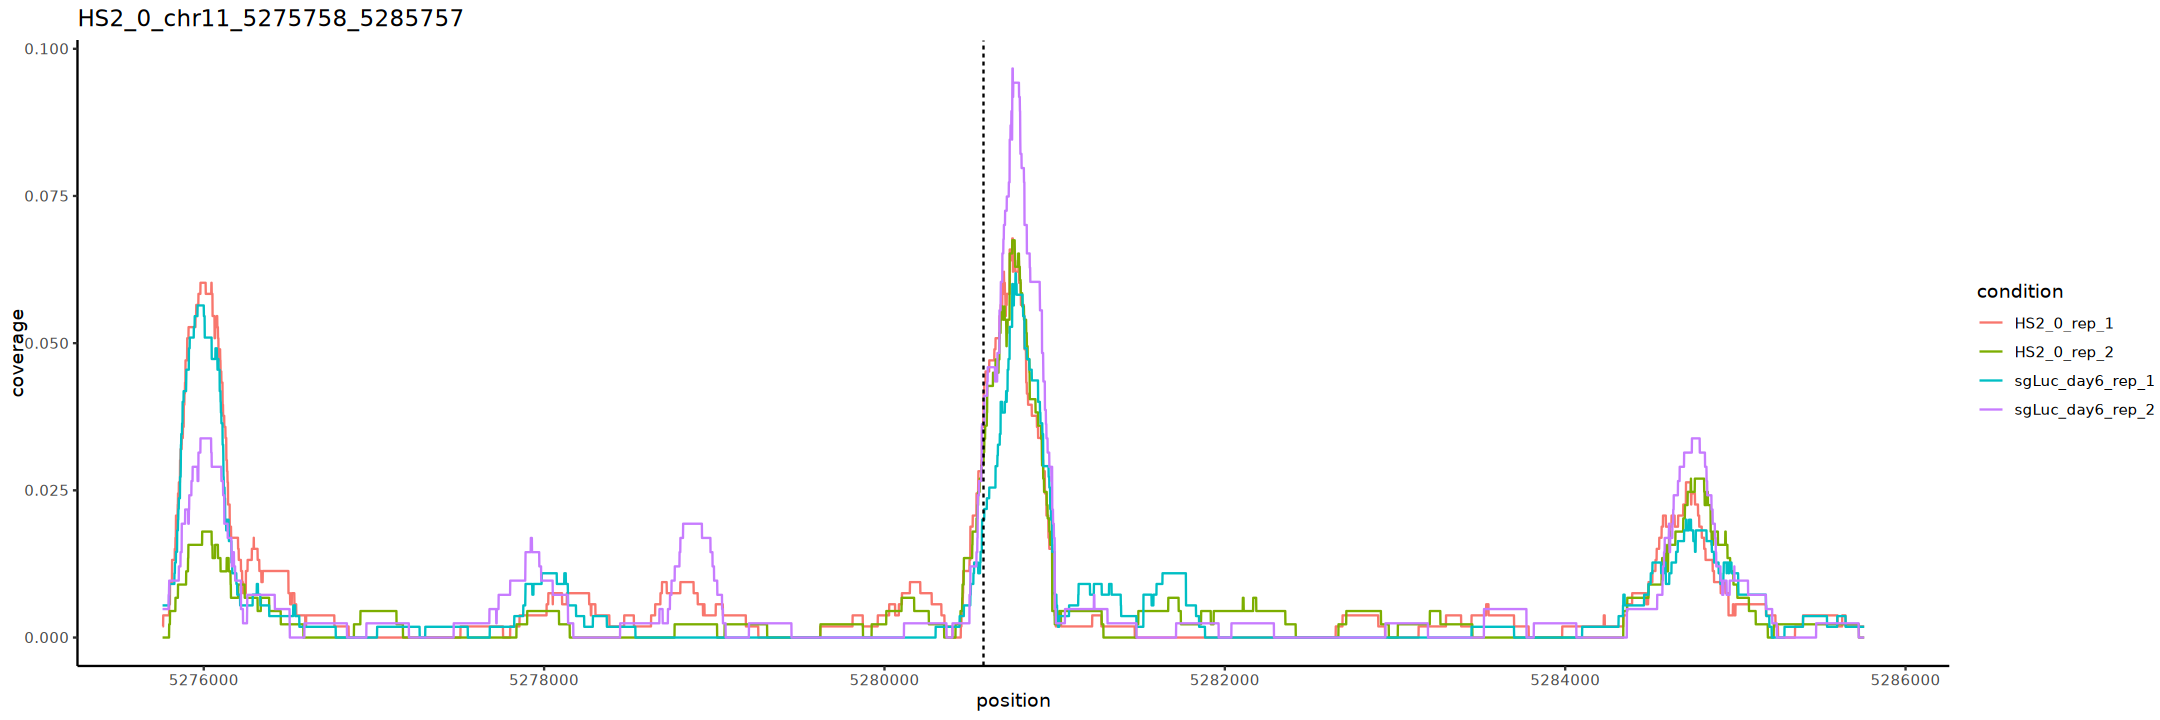

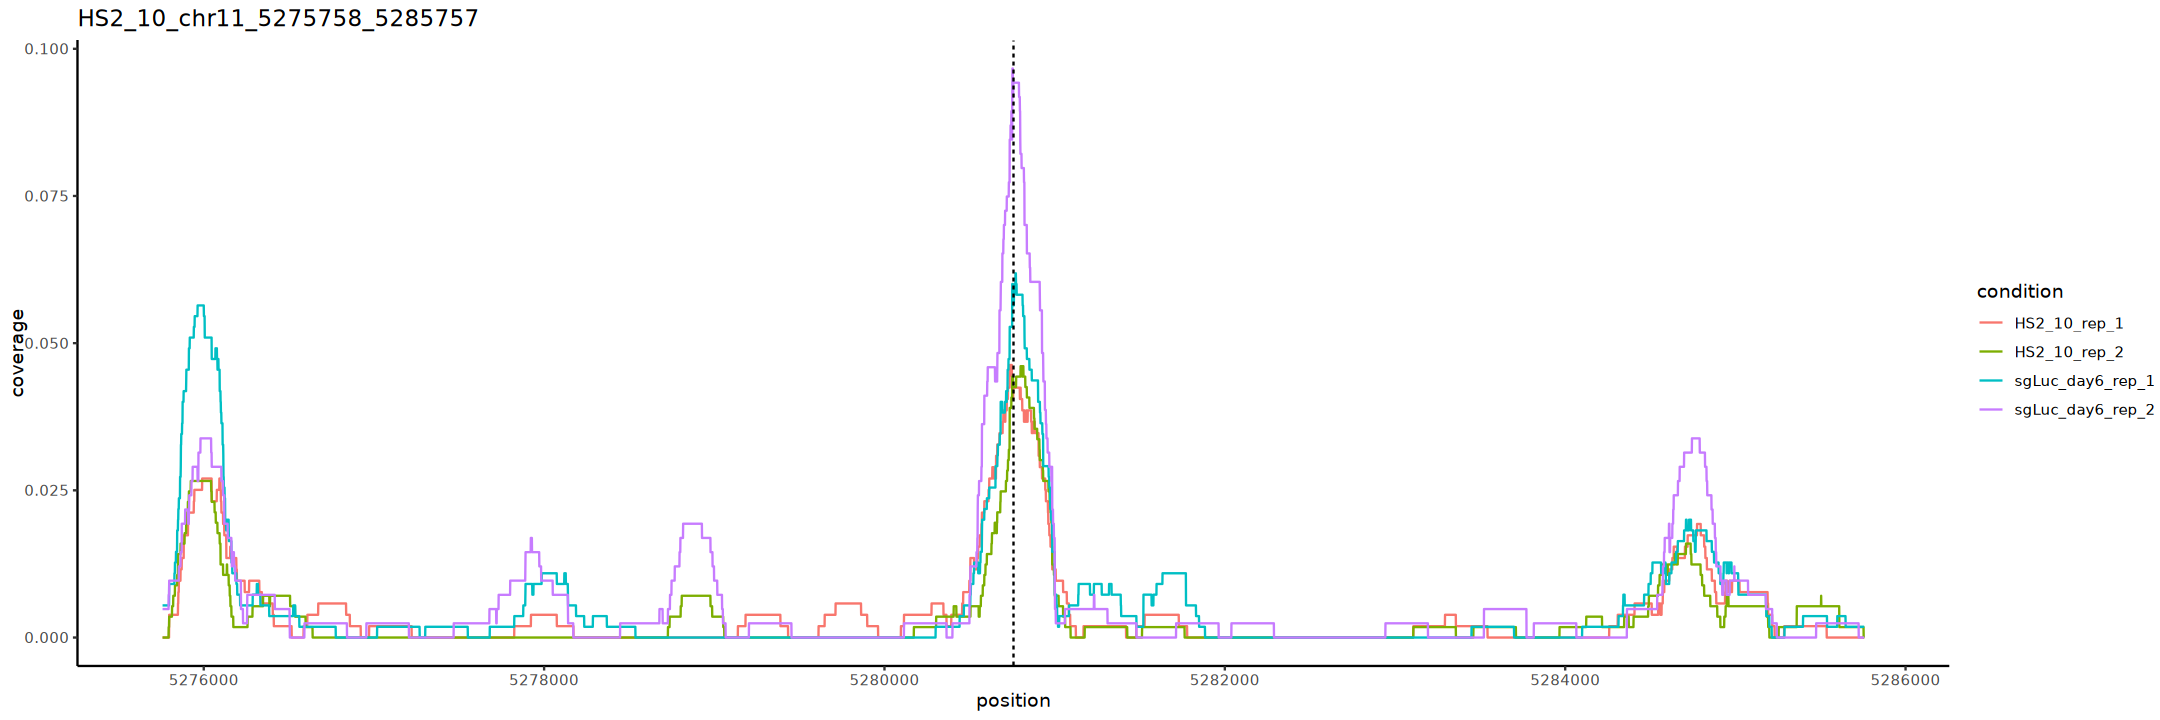

In [8]:
# Specify target site of each sgRNA
sgRNA_pos <- list(
    "HS2_0" = GRanges("chr11:5280570-5280589"),
    "HS2_10" = GRanges("chr11:5280748-5280767")
)

# Select sgRNA of interest
for(sgRNA_ind in 1:2){
    treated_id <- sgRNA_list[sgRNA_ind]
    control_id <- control_list[sgRNA_ind]
    mask <- metadata$condition %in% c(treated_id, control_id)
    sample_id_filt <- metadata$sample_ID[mask]
    sample_filt <- metadata$sample[mask]
    
    # Selecte target locus and divide into bins for coverage quantification
    locus_list <- c(
        rep(resize(GRanges("chr11:5278758-5282757"), 10000, fix="center"), 2) # HS2
    )
    locus <- locus_list[sgRNA_ind]
    locusBins <- tile(locus, width = 1)[[1]]
    
    # Calculate coverage tracks within the target locus for each selecte sample
    frags_dir <- "/home/yanhu/data/DddA/HJR269/fragments/"
    tracks <- pbmcapply::pbmcmapply(
      function(sample){
        
        # Load fragment coordinates of the current sample
        frags <- data.table::fread(
          paste0(frags_dir, sample, ".frags.gz"), sep = "\t"
        )[, 1:4]
        colnames(frags) <- c("chr", "start", "end", "barcode")
    
        # Filter out incorrect pairs
        frags <- frags[frags$end > frags$start,]
        
        # Calculate coverage track within the target locus
        fragRanges <- c(GRanges(seqnames = frags$chr, ranges = IRanges(start = frags$start, end = frags$start)),
                        GRanges(seqnames = frags$chr, ranges = IRanges(start = frags$end, end = frags$end)))
        nMillionFrags <- dim(frags)[1] / 1e6
        coverage <- as.integer(table(factor(findOverlaps(locusBins, fragRanges)@from, levels = 1:length(locusBins))))
        coverageRPM <- coverage / nMillionFrags # Normalize to get read-per-million

        # Smooth coverage tracks
        coverageRPM <- conv(coverageRPM, 125)/250
          
      },
      sample_filt,
      mc.cores = 4
    )
    colnames(tracks) <- sample_id_filt
    
    # Reformat into data.frame for visualization
    plot_data <- lapply(
        sample_id_filt,
        function(sample){
            data.frame(
                position = start(resize(locusBins, 1, fix = "center")),
                coverage = tracks[, sample],
                condition = sample
            )
        }
    )
    plot_data <- data.table::rbindlist(plot_data)
    
    options(repr.plot.width = 18, repr.plot.height = 6)
    plot_title <- paste0(treated_id, "_", seqnames(locus), "_", start(locus), "_", end(locus))
    p <- ggplot(plot_data) +
      geom_line(aes(x=position, y=coverage, color=condition)) +
      geom_vline(
          xintercept=start(resize(sgRNA_pos[[sgRNA_ind]], 1, fix="center")),
          linetype="dashed"
      ) +
      ggtitle(plot_title) +
      theme_classic()
    pdf(paste0("/home/yanhu/data/DddA/HJR269/plots/accessibility_tracks_", plot_title, ".pdf"), 
       width=12, height=4)
    print(p)
    dev.off()
    print(p)

    # Export the track of each sample to bigwig
    bw_dir <- "/home/yanhu/data/DddA/HJR269/bigwigs/"
    library(TxDb.Hsapiens.UCSC.hg38.knownGene)
    txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
    for(sample in colnames(tracks)){
        bw <- locusBins
        bw$score <- tracks[, sample]
        seqinfo(bw) <- seqinfo(txdb)[seqnames(seqinfo(bw))]
        rtracklayer::export.bw(bw, paste0(bw_dir, sample, "_", as.character(locus), ".bigwig"), format = 'bigWig')
    }

    # Calculate the average across replicates
    conditions <- stringr::str_split_fixed(colnames(tracks), "_rep", 3)[, 1]
    for(condition in unique(conditions)){
        bw <- locusBins
        bw$score <- rowMeans(tracks[, conditions == condition])
        seqinfo(bw) <- seqinfo(txdb)[seqnames(seqinfo(bw))]
        rtracklayer::export.bw(bw, paste0(bw_dir, condition, "_", as.character(locus), ".bigwig"), format = 'bigWig')
    }
}